In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer


In [2]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [14]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]
# hypotheses = [
#     "People feel that surveillance cameras in public spaces negatively impact their privacy.",
#     "Individuals believe that surveillance cameras effectively reduce crime in their neighborhoods and public areas.",
#     "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
#     "Trust in the organizations that manage surveillance cameras is influenced by specific factors such as transparency and accountability.",
#     "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
#     "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
#     "Surveillance cameras make people feel more secure rather than feeling watched.",
#     "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
# ]

In [5]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
0,1000lbbestfriends,thread_start,20,https://www.reddit.com/r/1000lbbestfriends/com...,u/AutoModerator,2/1/2023 10:30,10qofh3,0,1000lb Best Friends - 2x5 - Episode Discussion,Available Wednesdays on Discovery+ at 1AM PT/4...,lb best friends x episode discussion,available wednesdays on discovery at am et and...,lb best friends x episode discussion availab...
1,1000lbbestfriends,comment,1,https://www.reddit.com/r/1000lbbestfriends/com...,u/ShesInCybersecurity,2/5/2023 9:52,10qofh3,j7abcqe,1000lb Best Friends - 2x5 - Episode Discussion,"I didn’t agree with it, but it could’ve been a...",lb best friends x episode discussion,i did not agree with it but it couldve been a ...,lb best friends x episode discussion i did n...
2,1000lbbestfriends,comment,10,https://www.reddit.com/r/1000lbbestfriends/com...,u/perfect_fifths,2/1/2023 19:19,10qofh3,j6ssti9,1000lb Best Friends - 2x5 - Episode Discussion,I don’t know if I’d call her a terrible parent...,lb best friends x episode discussion,i do not know if id call her a terrible parent...,lb best friends x episode discussion i do no...
3,1000lbbestfriends,comment,24,https://www.reddit.com/r/1000lbbestfriends/com...,u/bitchvirgo,2/1/2023 23:04,10qofh3,j6ttnp7,1000lb Best Friends - 2x5 - Episode Discussion,My thought it what if they see him jacking off...,lb best friends x episode discussion,my thought it what if they see him jacking off...,lb best friends x episode discussion my thou...
4,1000lbsisters,thread_start,125,https://www.reddit.com/r/1000lbsisters/comment...,u/AveryNicoleMyers,2/17/2023 10:26,114eg4v,0,Do y’all think the scene where Amy finds out s...,"Everything is off about it, why didn’t the cam...",do yall think the scene where amy finds out sh...,everything is off about it why did not the cam...,do yall think the scene where amy finds out sh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975992,Zoomies,comment,69,https://www.reddit.com/r/Zoomies/comments/10y9...,u/wind-river7,2/10/2023 1:13,10y975k,j7wrief,"Caught on my surveillance cameras, Beans (corg...","Corgi with the zoomies, shih tzu observing.",caught on my surveillance cameras beans corgi ...,corgi with the zoomies shih tzu observing,caught on my surveillance cameras beans corgi ...
975993,zurich,thread_start,267,https://www.reddit.com/r/zurich/comments/11ci8...,u/ares55,2/26/2023 16:16,11ci8qd,0,Why are people like this? Spotted in alstetten,NaN,why are people like this spotted in alstetten,NaN,why are people like this spotted in alstetten
975994,zurich,comment,1,https://www.reddit.com/r/zurich/comments/11ci8...,u/PomeloLongjumping537,2/26/2023 19:33,11ci8qd,ja3w0dw,Why are people like this? Spotted in alstetten,"Of course confrontation didn’t solve anything,...",why are people like this spotted in alstetten,of course confrontation did not solve anything...,why are people like this spotted in alstetten ...
975995,zurich,comment,6,https://www.reddit.com/r/zurich/comments/11ci8...,u/roat_it,2/26/2023 20:18,11ci8qd,ja42vek,Why are people like this? Spotted in alstetten,IIRC the [Kantonsrat](https://www.limmattalerz...,why are people like this spotted in alstetten,iirc the had a debate last year about a petit...,why are people like this spotted in alstetten ...


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [52]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl')

In [6]:
texts = df['combined_processed'].tolist()

# Generate embeddings in batches
batch_size = 10000
combined_embeddings = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    combined_embeddings.append(batch_embeddings)

# Concatenate all batches
combined_embeddings = torch.cat(combined_embeddings, dim=0)

# Save text embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_embeddings.pkl', 'wb') as f:
    torch.save(combined_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



Processing batches: 100%|██████████| 98/98 [23:50<00:00, 14.59s/it]


In [5]:
# Load saved embeddings
combined_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_embeddings.pkl')

In [16]:
# Calculate cosine similarity between text and hypothesis embeddings
# thread_text_similarity_scores = torch.mm(thread_text_embeddings, hypothesis_embeddings.T).cpu().numpy()
combined_similarity_scores = torch.mm(combined_embeddings, hypothesis_embeddings.T).cpu().numpy()

# Save similarity scores
# with open('thread_text_similarity_scores.pkl', 'wb') as f:
#     pickle.dump(thread_text_similarity_scores, f)
# Save similarity scores
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_similarity_scores.pkl', 'wb') as f:
    pickle.dump(combined_similarity_scores, f)

In [6]:
# similarity_scores = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/similarity_scores.pkl')
# Loading with pickle
# with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/thread_text_similarity_scores.pkl', 'rb') as f:
#     thread_text_similarity_scores = pickle.load(f)
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_similarity_scores.pkl', 'rb') as f:
    combined_similarity_scores = pickle.load(f)

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


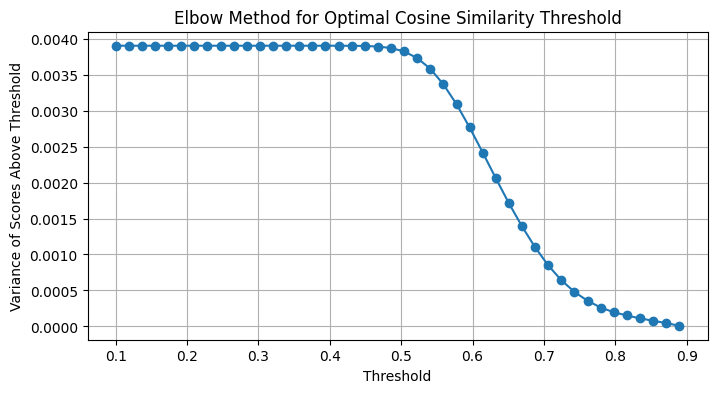

In [17]:
# Assuming 'similarity_scores' is a 2D array where each row corresponds to a document and each column to a hypothesis
thresholds = np.linspace(0.1, 1, 50)  # Adjust as needed for your range of similarity scores
variances = []

for threshold in thresholds:
    filtered_scores = combined_similarity_scores[combined_similarity_scores > threshold]
    variance = np.var(filtered_scores)
    variances.append(variance)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(thresholds, variances, marker='o')
plt.title('Elbow Method for Optimal Cosine Similarity Threshold')
plt.xlabel('Threshold')
plt.ylabel('Variance of Scores Above Threshold')
plt.grid(True)
plt.show()


In [18]:
threshold = 0.5
max_scores = np.max(combined_similarity_scores, axis=1)
df_temp = pd.DataFrame()
df_temp['Max_Similarity_Score'] = max_scores
df_temp['classified'] = df_temp['Max_Similarity_Score'] >= threshold

# Count classified and unclassified
classified_count = df_temp['classified'].sum()
unclassified_count = (~df_temp['classified']).sum()

print(f"Classified Rows: {classified_count}")
print(f"Unclassified Rows: {unclassified_count}")

Classified Rows: 975754
Unclassified Rows: 243


In [19]:
threshold = 0.5
max_indices = np.argmax(combined_similarity_scores, axis=1)  # Indices of max similarity score per row
max_scores = np.max(combined_similarity_scores, axis=1)  # Max scores per row

# Map indices to hypothesis labels if score exceeds threshold, else assign -1
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['combined_hypothesis'] = [hypothesis_labels[idx] if score > threshold else -1 for idx, score in zip(max_indices, max_scores)]

In [20]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses.csv', index=False)

combined_hypothesis
H3    324171
H2    241507
H0    164645
H1    146086
H4     99345
-1       243
Name: count, dtype: int64


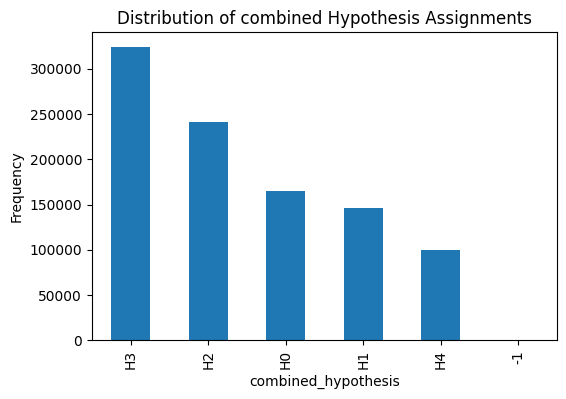

In [21]:
# Optional: Display a histogram of the assigned hypotheses
print(df['combined_hypothesis'].value_counts())
df['combined_hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of combined Hypothesis Assignments')
plt.xlabel('combined_hypothesis')
plt.ylabel('Frequency')
plt.show()

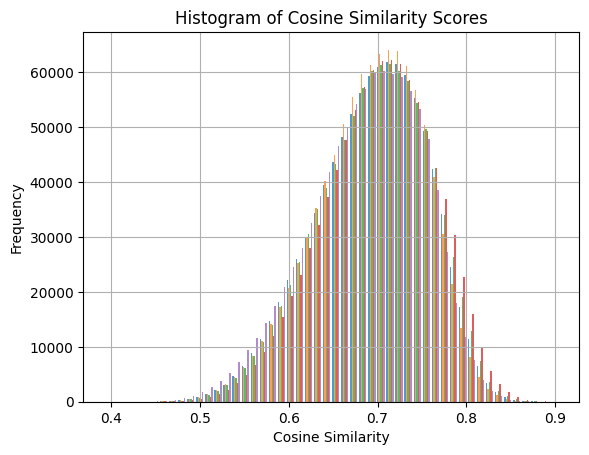

In [22]:
# Assuming `similarity_scores` is a numpy array of your cosine similarity scores
plt.hist(combined_similarity_scores, bins=50, alpha=0.75)
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [23]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,combined_hypothesis
0,1000lbbestfriends,thread_start,20,https://www.reddit.com/r/1000lbbestfriends/com...,u/AutoModerator,2/1/2023 10:30,10qofh3,0,1000lb Best Friends - 2x5 - Episode Discussion,Available Wednesdays on Discovery+ at 1AM PT/4...,lb best friends x episode discussion,available wednesdays on discovery at am et and...,lb best friends x episode discussion availab...,H0
1,1000lbbestfriends,comment,1,https://www.reddit.com/r/1000lbbestfriends/com...,u/ShesInCybersecurity,2/5/2023 9:52,10qofh3,j7abcqe,1000lb Best Friends - 2x5 - Episode Discussion,"I didn’t agree with it, but it could’ve been a...",lb best friends x episode discussion,i did not agree with it but it couldve been a ...,lb best friends x episode discussion i did n...,H3
2,1000lbbestfriends,comment,10,https://www.reddit.com/r/1000lbbestfriends/com...,u/perfect_fifths,2/1/2023 19:19,10qofh3,j6ssti9,1000lb Best Friends - 2x5 - Episode Discussion,I don’t know if I’d call her a terrible parent...,lb best friends x episode discussion,i do not know if id call her a terrible parent...,lb best friends x episode discussion i do no...,H3
3,1000lbbestfriends,comment,24,https://www.reddit.com/r/1000lbbestfriends/com...,u/bitchvirgo,2/1/2023 23:04,10qofh3,j6ttnp7,1000lb Best Friends - 2x5 - Episode Discussion,My thought it what if they see him jacking off...,lb best friends x episode discussion,my thought it what if they see him jacking off...,lb best friends x episode discussion my thou...,H3
4,1000lbsisters,thread_start,125,https://www.reddit.com/r/1000lbsisters/comment...,u/AveryNicoleMyers,2/17/2023 10:26,114eg4v,0,Do y’all think the scene where Amy finds out s...,"Everything is off about it, why didn’t the cam...",do yall think the scene where amy finds out sh...,everything is off about it why did not the cam...,do yall think the scene where amy finds out sh...,H3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975992,Zoomies,comment,69,https://www.reddit.com/r/Zoomies/comments/10y9...,u/wind-river7,2/10/2023 1:13,10y975k,j7wrief,"Caught on my surveillance cameras, Beans (corg...","Corgi with the zoomies, shih tzu observing.",caught on my surveillance cameras beans corgi ...,corgi with the zoomies shih tzu observing,caught on my surveillance cameras beans corgi ...,H3
975993,zurich,thread_start,267,https://www.reddit.com/r/zurich/comments/11ci8...,u/ares55,2/26/2023 16:16,11ci8qd,0,Why are people like this? Spotted in alstetten,NaN,why are people like this spotted in alstetten,NaN,why are people like this spotted in alstetten,H1
975994,zurich,comment,1,https://www.reddit.com/r/zurich/comments/11ci8...,u/PomeloLongjumping537,2/26/2023 19:33,11ci8qd,ja3w0dw,Why are people like this? Spotted in alstetten,"Of course confrontation didn’t solve anything,...",why are people like this spotted in alstetten,of course confrontation did not solve anything...,why are people like this spotted in alstetten ...,H4
975995,zurich,comment,6,https://www.reddit.com/r/zurich/comments/11ci8...,u/roat_it,2/26/2023 20:18,11ci8qd,ja42vek,Why are people like this? Spotted in alstetten,IIRC the [Kantonsrat](https://www.limmattalerz...,why are people like this spotted in alstetten,iirc the had a debate last year about a petit...,why are people like this spotted in alstetten ...,H0
